In [2]:
# All imports
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from skimage import measure
from skimage.morphology import skeletonize
from scipy import signal
from scipy.ndimage import convolve
from scipy.optimize import curve_fit
from scipy.signal import hilbert
import networkx as nx
import glob

In [3]:
# Helper functions
def build_skeleton_graph(mask):
    """Build a pixel-level graph from a binary mask's skeleton."""
    skel = skeletonize(mask)
    coords = [tuple(p) for p in np.transpose(np.where(skel))]
    if len(coords) == 0:
        return None, skel, []
    
    G = nx.Graph()
    dirs = [(-1,-1),(-1,0),(-1,1),(0,-1),(0,1),(1,-1),(1,0),(1,1)]
    skel_set = set(coords)
    
    for p in coords:
        G.add_node(p)
    for p in coords:
        y, x = p
        for dy, dx in dirs:
            q = (y+dy, x+dx)
            if q in skel_set:
                G.add_edge(p, q, weight=1)
    
    return G, skel, coords

def find_main_trunk(G, coords):
    """Find main trunk path: topmost pixel to farthest pixel by graph distance."""
    if G is None or len(coords) == 0:
        return []
    start = min(coords, key=lambda p: p[0])
    lengths = nx.single_source_shortest_path_length(G, start)
    far = max(lengths, key=lengths.get)
    return nx.shortest_path(G, source=start, target=far)

def compute_theta_timeseries(path, dx_pixels):
    """Sample trunk path and compute angle timeseries."""
    pts = np.array(path, dtype=float)
    if pts.shape[0] < 2:
        return None, None
    
    # compute cumulative arc-length
    diffs = np.diff(pts, axis=0)
    seg_d = np.sqrt((diffs**2).sum(axis=1))
    cum = np.concatenate(([0.0], np.cumsum(seg_d)))
    total_len = cum[-1]
    
    if total_len <= dx_pixels:
        return None, None
    
    # sample along trunk
    sample_s = np.arange(0, total_len, dx_pixels)
    sample_pts = []
    for s in sample_s:
        i = np.searchsorted(cum, s) - 1
        i = max(0, min(i, len(seg_d)-1))
        seg_len = seg_d[i]
        t = (s - cum[i]) / seg_len if seg_len > 0 else 0.0
        p = pts[i] + t * (pts[i+1] - pts[i])
        sample_pts.append(p)
    
    # compute angles
    thetas = []
    for i in range(len(sample_pts)-1):
        p0, p1 = sample_pts[i], sample_pts[i+1]
        dy, dxv = p1[0] - p0[0], p1[1] - p0[1]
        theta = np.arctan2(dxv, dy)
        thetas.append(theta)
    
    xs = sample_s[:len(thetas)]
    return xs, np.array(thetas)

def compute_autocorr(x, max_lag=None):
    """Compute normalized autocorrelation with unbiased normalization."""
    x = np.asarray(x)
    n = len(x)
    mean, var = x.mean(), x.var()
    if var == 0:
        return np.array([1.0])
    
    x0 = x - mean
    full = np.correlate(x0, x0, mode='full')
    ac = full[n-1:]
    max_lag = min(max_lag or n-1, n-1)
    ac = ac[:max_lag+1].astype(float)
    
    for lag in range(len(ac)):
        ac[lag] = ac[lag] / (var * (n - lag))
    return ac

In [4]:
root_number_data = {
    '003-Ag-0-s-250612-002.bmp': 3,
    '003-Ag-0-v-250612-001.bmp': 5,
    '007-Amel-1-s-250612-005.bmp': 10,
    '007-Amel-1-v-250612-006.bmp': 10,
    '014-Baa-1-s-250612-018.bmp': 10,
    '014-Baa-1-v-250612-017.bmp': 10,
    '020-Ber-0-s-250612-003.bmp': 10,
    '020-Ber-0-v-250612-004.bmp': 9,
    '031-Cevr-1-s-250612-021.bmp': 9,
    '031-Cevr-1-v-250612-022.bmp': 11,
    '045-El-0-s-250612-011.bmp': 10,
    '045-El-0-v-250612-012.bmp': 11,
    '057-Gel-s-250612-019.bmp': 10,
    '057-Gel-v-250612-020.bmp': 10,
    '059-Gifu-2-s-250612-016.bmp': 10,
    '059-Gifu-2-v-250612-015.bmp': 10,
    '065-Hh-0-s-250612-014.bmp': 10,
    '065-Hh-0-v-250612-013.bmp': 10,
    '079-Ko-2-s-250612-009.bmp': 10,
    '079-Ko-2-v-250612-010.bmp': 10,
    '101-Neo-6-s-241217-187.bmp': 10,
    '101-Neo-6-v-241217-186.bmp': 8,
    '102-Nok-3-s-241217-191.bmp': 1,
    '102-Nok-3-v-241217-190.bmp': 1,
    '103-Np-7-s-241217-193.bmp': 2,
    '103-Np-7-v-241217-192.bmp': 0,
    '104-Nw-0-s-241217-195.bmp': 9,
    '104-Nw-0-v-241217-194.bmp': 9,
    '105-Ob-0-s-241217-197.bmp': 8,
    '105-Ob-0-v-241217-196.bmp': 10,
    '106-Old-1-s-241217-199.bmp': 7,
    '106-Old-1-v-241217-198.bmp': 7,
    '107-Or-0-s-241223-200.bmp': 11,
    '107-Or-0-v-241223-201.bmp': 8,
    '108-Ove-0-s-241223-203.bmp': 6,
    '108-Ove-0-v-241223-202.bmp': 8,
    '109-Per-1-s-241223-204.bmp': 6,
    '109-Per-1-v-241223-205.bmp': 8,
    '110-P1-0-s-241223-207.bmp': 7,
    '110-P1-0-v-241223-206.bmp': 7,
    '111-Pla-0-s-241223-209.bmp': 10,
    '111-Pla-0-v-241223-208.bmp': 9,
    '112-PnA-17-s-241223-210.bmp': 7,
    '112-PnA-17-v-241223-211.bmp': 10,
    '113-Pog-0-s-241223-212.bmp': 3,
    '113-Pog-0-v-241223-213.bmp': 4,
    '114-Pu2-23-s-241223-215.bmp': 3,
    '114-Pu2-23-v-241223-214.bmp': 3,
    '115-Pu2-7-s-241223-217.bmp': 4,
    '115-Pu2-7-v-241223-216.bmp': 5,
    '116-Qar-8a-s-241223-218.bmp': 8,
    '116-Qar-8a-v-241223-219.bmp': 9,
    '117-Ra-0-s-241223-221.bmp': 7,
    '117-Ra-0-v-241223-220.bmp': 8,
    '119-Rd-0-s-241223-222.bmp': 8,
    '119-Rd-0-v-241223-223.bmp': 10,
    '120-Rld-1-s-250130-225.bmp': 9,
    '120-Rld-1-v-250130-224.bmp': 6,
    '121-Rome-1-s-250130-226.bmp': 7,
    '121-Rome-1-v-250130-227.bmp': 6,
    '123-RRs-10-s-250130-228.bmp': 9,
    '123-RRs-10-v-250130-229.bmp': 9,
    '124-RRs-7-s-250130-231.bmp': 5,
    '124-RRs-7-v-250130-230.bmp': 7,
    }

## Exploratory

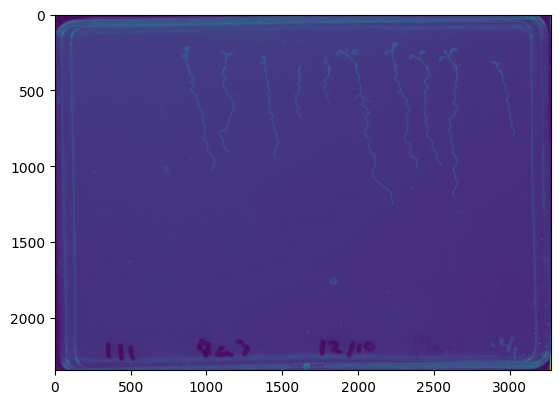

In [ ]:
# im = plt.imread("../../data/raw/116-Qar-8a-s-241223-218.bmp")
im = plt.imread("../../data/raw/111-Pla-0-s-241223-209.bmp")
# im = plt.imread("../../data/raw/107-Or-0-v-241223-201.bmp")
# im = plt.imread("../../data/raw/102-Nok-3-s-241217-191.bmp")

plt.imshow(im)

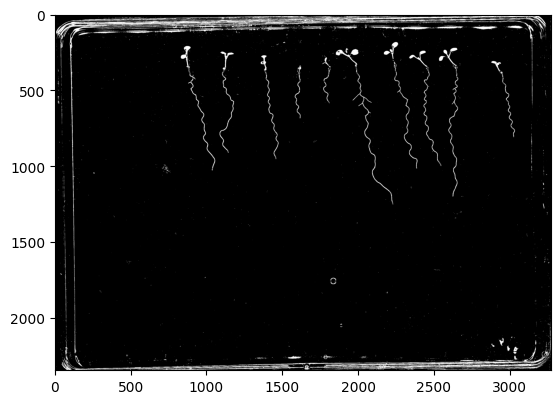

In [6]:
min_threshold = 55
max_threshold = 75

mask = (im >= min_threshold) & (im <= max_threshold)

plt.imshow(mask, cmap='gray')

Number of connected components: 4389


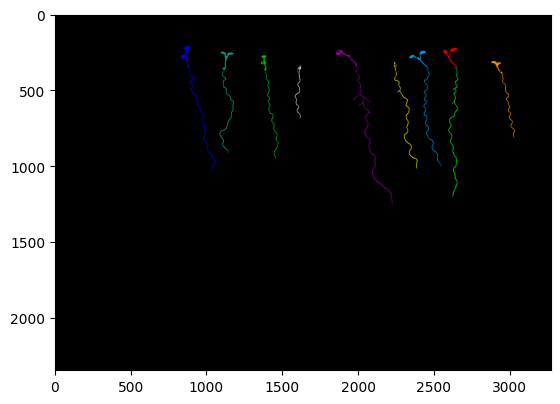

In [7]:
# pick how many components to keep (moveable parameter)
top_n = 10

# use connected component analysis to isolate root structures
labeled_mask = measure.label(mask, connectivity=2)
print(f"Number of connected components: {labeled_mask.max()}")

# remove components that are too wide or too short relative to their width
image_width = im.shape[1]
labels_to_remove = set()
for region in measure.regionprops(labeled_mask):
    minr, minc, maxr, maxc = region.bbox
    x_extent = maxc - minc
    y_extent = maxr - minr
    # too wide (likely background) or too short (noise/artefact) or too thin (vertical borderline)
    if x_extent >= 0.75 * image_width or y_extent <= 0.3 * x_extent or x_extent <= 20:
        labels_to_remove.add(region.label)

# zero-out the unwanted labels in one pass
if labels_to_remove:
    for lbl in labels_to_remove:
        labeled_mask[labeled_mask == lbl] = 0

# keep only the top_n largest remaining components
regions = measure.regionprops(labeled_mask)
regions = sorted(regions, key=lambda r: r.area, reverse=True)
top_labels = [r.label for r in regions[:top_n]]

# relabel: background=0, components=1..top_n (so values range 0..top_n)
relabeled = np.zeros_like(labeled_mask, dtype=int)
for i, lbl in enumerate(top_labels, start=1):
    relabeled[labeled_mask == lbl] = i

# display with a discrete colormap so each label has a distinct color
cmap = plt.get_cmap('nipy_spectral', top_n+1)
norm = colors.BoundaryNorm(np.arange(top_n+2)-0.5, cmap.N)
plt.imshow(relabeled, cmap=cmap, norm=norm)

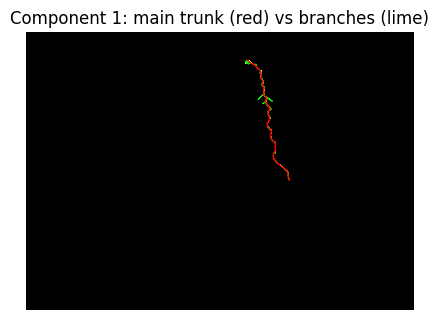

In [8]:
# Plot single component: main trunk (red) vs side branches (lime)
component_idx = 1

mask_comp = (relabeled == component_idx)
if mask_comp.sum() == 0:
    print(f"Component {component_idx} not present.")
else:
    G, skel, coords = build_skeleton_graph(mask_comp)
    if G is None:
        print('Empty skeleton')
    else:
        main_path = find_main_trunk(G, coords)
        
        # build set of trunk edges (unordered) to exclude when plotting branches
        trunk_edge_set = set()
        for a, b in zip(main_path, main_path[1:]):
            trunk_edge_set.add(frozenset((tuple(a), tuple(b))))
        
        plt.figure(figsize=(5,5))
        plt.imshow(mask_comp, cmap='gray', interpolation='nearest')
        
        # Draw all skeleton edges (branches) but skip trunk edges
        for u, v in G.edges():
            edge_key = frozenset((u, v))
            if edge_key in trunk_edge_set:
                continue
            uy, ux = u
            vy, vx = v
            plt.plot([ux, vx], [uy, vy], color='lime', linewidth=0.5)
        
        # Draw main trunk
        if len(main_path) > 0:
            arr = np.array(main_path)
            plt.plot(arr[:,1], arr[:,0], color='red', linewidth=1)
        
        plt.title(f'Component {component_idx}: main trunk (red) vs branches (lime)')
        plt.axis('off')
        # plt.xlim(1200, 1600)
        # plt.ylim(200, 1000)
        plt.show()

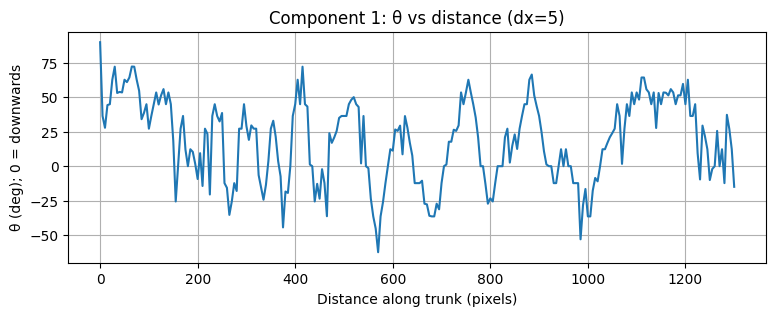

In [9]:
# Theta vs distance along main trunk
component_idx = 1
dx_pixels = 5

mask_comp = (relabeled == component_idx)
if mask_comp.sum() == 0:
    print(f"Component {component_idx} not present.")
else:
    G, skel, coords = build_skeleton_graph(mask_comp)
    if G is None:
        print('Empty skeleton')
    else:
        main_path = find_main_trunk(G, coords)
        xs, thetas = compute_theta_timeseries(main_path, dx_pixels)
        
        if thetas is None:
            print('Trunk too short or path invalid')
        else:
            thetas_deg = np.degrees(thetas)
            plt.figure(figsize=(9,3))
            plt.plot(xs, thetas_deg)
            plt.xlabel('Distance along trunk (pixels)')
            plt.ylabel('θ (deg); 0 = downwards')
            plt.title(f'Component {component_idx}: θ vs distance (dx={dx_pixels})')
            plt.grid(True)
            plt.show()

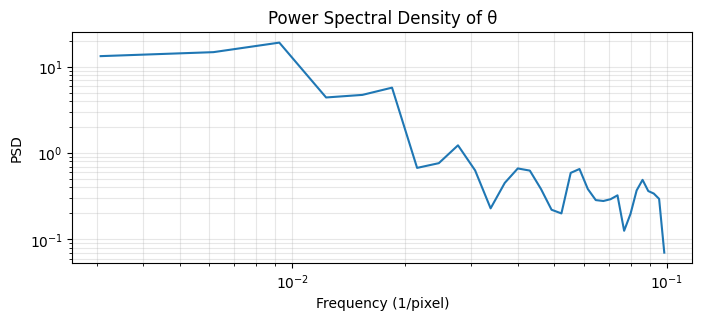

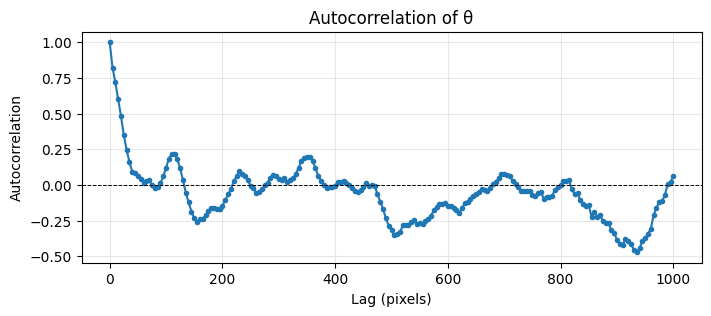

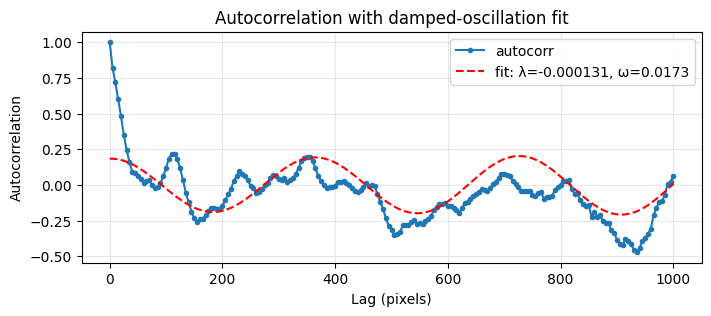

In [10]:
# Power spectrum and autocorrelation of θ timeseries
if 'thetas' not in dir() or thetas is None:
    print('Run previous cell first to generate theta timeseries')
else:
    dt = dx_pixels
    fs = 1.0 / dt
    n = len(thetas)
    
    if n < 4:
        print('Timeseries too short for spectral analysis')
    else:
        # Power spectral density
        nperseg = min(max(8, n//4), 1024)
        freqs, psd = signal.welch(thetas, fs=fs, nperseg=nperseg)
        
        plt.figure(figsize=(8,3))
        plt.loglog(freqs[1:], psd[1:])
        plt.xlabel('Frequency (1/pixel)')
        plt.ylabel('PSD')
        plt.title('Power Spectral Density of θ')
        plt.grid(True, which='both', alpha=0.3)
        plt.show()
        
        # Autocorrelation
        max_lag = min(200, n-1)
        ac = compute_autocorr(thetas, max_lag=max_lag)
        lags = np.arange(len(ac)) * dt
        
        plt.figure(figsize=(8,3))
        plt.plot(lags, ac, '-o', markersize=3)
        plt.xlabel('Lag (pixels)')
        plt.ylabel('Autocorrelation')
        plt.title('Autocorrelation of θ')
        plt.grid(True, alpha=0.3)
        plt.axhline(0, color='k', linestyle='--', linewidth=0.7)
        plt.show()
        
        # Damped oscillation fit
        def damped(t, A, lam, omega, phi):
            return A * np.exp(-lam * t) * np.cos(omega * t + phi)
        
        try:
            fft_vals = np.fft.fft(ac)
            freqs_ac = np.fft.fftfreq(len(ac), d=dt)
            half = len(fft_vals)//2
            if half > 2:
                peak_idx = np.argmax(np.abs(fft_vals[1:half])) + 1
                omega_guess = 2 * np.pi * abs(freqs_ac[peak_idx])
                
                env = np.abs(hilbert(ac))
                valid = env > 0.01 * np.max(env)
                if np.sum(valid) > 5:
                    popt_env, _ = curve_fit(lambda t, A, lam: A * np.exp(-lam * t), 
                                           lags[valid], env[valid], p0=[env[valid][0], 0.01], maxfev=2000)
                    lambda_guess = popt_env[1]
                else:
                    lambda_guess = 0.01
                
                popt, _ = curve_fit(damped, lags, ac, p0=[ac[0], lambda_guess, omega_guess, 0.0], maxfev=8000)
                fit_ac = damped(lags, *popt)
                
                plt.figure(figsize=(8,3))
                plt.plot(lags, ac, '-o', markersize=3, label='autocorr')
                plt.plot(lags, fit_ac, '--', color='r', label=f'fit: λ={popt[1]:.3g}, ω={popt[2]:.3g}')
                plt.xlabel('Lag (pixels)')
                plt.ylabel('Autocorrelation')
                plt.title('Autocorrelation with damped-oscillation fit')
                plt.legend()
                plt.grid(True, alpha=0.3)
                plt.show()
        except Exception as e:
            print(f'Damped-oscillation fit failed: {e}')